<a href="https://colab.research.google.com/github/seungmei/ESAA_24_1/blob/main/0429%EC%9B%94%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EB%A8%B8%EC%99%84_Ch8_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D_pg_544~561.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0429월과제 파머완 Ch8 텍스트분석 pg. 544~561

## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge
- 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격price 예측하는 과제

### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/mercari-price-suggestion/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
print(mercari_df.info())
'''
brand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터값이 NULL.
category_name도 꽤 많음.
item_description은 4건으로 미미하기 때문에 적절한 문자열로 치환
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


'\nbrand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터값이 NULL.\ncategory_name도 꽤 많음.\nitem_description은 4건으로 미미하기 때문에 적절한 문자열로 치환\n'

<Figure size 600x400 with 0 Axes>

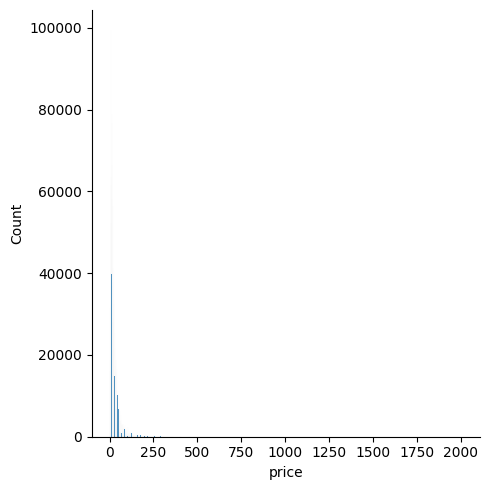

In [3]:
# target 값인 price칼럼의 데이터 분포도 살펴보기 ∵ 회귀에서 target 값의 정규 분포도 매우 중요
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.displot(y_train_df, kde=False)

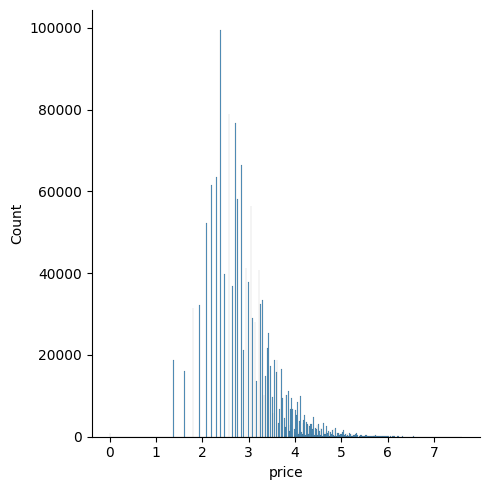

In [4]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

In [5]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [6]:
# shipping: 배송비 유무. 값 균일.
# item_condition_d: 판매자가 제공하는 제품 상태.
print('Shopping 값 유형: \n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shopping 값 유형: 
 shipping
0    819435
1    663100
Name: count, dtype: int64
item_condition_id 값 유형: 
 item_condition_id
1    640549
3    432161
2    375479
4     31962
5      2384
Name: count, dtype: int64


In [7]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()
## No description yet은 의미있는 속상값으로 사용될 수 없으므로 적절한 값으로 변경해야

82489

In [8]:
'''
category_name은 텍스트. 피처 추출 시 tokenizer를 /로 하여 단어를 분리해 벡터화하거나 단어를 토큰화해 각각 별도의 피처로 저장하고 알고리즘을 학습.
apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
'''
def split_cat(category_name):
  try:
    return category_name.split('/')
  except:
    return ['Other_Null', 'Other_Null', 'Other_Null']

#위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df 에 생성
mercari_df["cat_dae"], mercari_df["cat_jung"], mercari_df["cat_so"] = \
                                               zip(*mercari_df["category_name"].apply(lambda x: split_cat(x)))

#대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 개수:', mercari_df['cat_jung'].nunique())
print('소분류 개수:', mercari_df['cat_so'].nunique())

대분류 유형: 
 cat_dae
Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: count, dtype: int64
중분류 개수: 114
소분류 개수: 871


In [9]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

#각 칼럼별로 Null 값 건수 확인. 모두 0이 나와야.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화
- 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별해보기.
- 이 피처를 어떤 방식으로 변환할지 검토한 후에 ~> 일괄적으로 전체 속성의 변환 작업을 적용해야 ~> 선형 회귀 모델과 회귀 트리 모델을 모두 적용하여 원핫인코딩 or 피처 벡터화(짧:count기반/긴:TD-IDF기반)


In [10]:
# brand_name 검토
print('brand name의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])
## brand_name의 경우 대부분 명료한 문자열로 돼있음. 별도의 피처 벡터화 형태로 만들 필요는 없이 인코딩 변환하기 -> 원핫인코딩

brand name의 유형 건수: 4810
brand name sample 5건: 
 brand_name
Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: count, dtype: int64


In [11]:
print('name의 종류 개수:', mercari_df['name'].nunique())
print('name sample 10건: \n', mercari_df['name'][:10])
##name 속성은 유형이 매우 많고 적은 단어 위주의 텍스트 형태로 되어 있으므로 count기반 피처 벡터화 적용

name의 종류 개수: 1225273
name sample 10건: 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


In [12]:
# item_description 검토
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]
## 문자열이 비교적 크므로 해당 칼럼은 TF-IDF 변환

item_description 평균 문자열 크기: 145.71139703278507


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [13]:
# 주요 칼럼 인코딩 및 피처 벡터화 변환

# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)


# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1,3), stop_words="english")
X_descp = tfidf_descp.fit_transform(mercari_df["item_description"])

print("name vectorization shape:", X_name.shape)
print("item_description vectorization shape:", X_descp.shape)

'''
CountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태.
희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야.
앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML모델을 실행하는 기반 데이터 세트로 재구성돼야
이를 위해서 인코딩 대상 칼럼도 밀집 행렬 형태X, 희소 행렬 형태로 인코딩 적용 ~> 함께 결
'''

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


'\nCountVectorizer, TfidfVectorizer가 fit_transform()을 통해 반환하는 데이터는 희소 행렬 형태.\n희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야.\n앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML모델을 실행하는 기반 데이터 세트로 재구성돼야\n이를 위해서 인코딩 대상 칼럼도 밀집 행렬 형태X, 희소 행렬 형태로 인코딩 적용 ~> 함께 결\n'

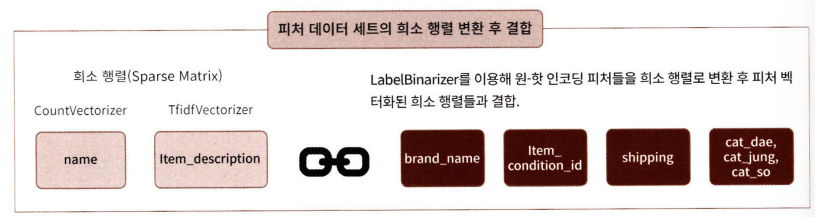

In [14]:
from sklearn.preprocessing import LabelBinarizer


# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df["brand_name"])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df["item_condition_id"])
lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df["shipping"])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df["cat_dae"])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df["cat_jung"])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df["cat_so"])

In [15]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))

print("X_brand shape: {0}, X_item_cond_id shape: {1}".format(X_brand.shape, X_item_cond_id.shape))
print("X_shipping shape : {0}, X_cat_dae shape: {1}".format(X_shipping.shape, X_cat_dae.shape))
print("X_cat_jung shape: {0}, X_cat_so shape: {1}".format(X_cat_jung.shape, X_cat_so.shape))
## 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입
'''
인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제X
'''

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape: (1482535, 5)
X_shipping shape : (1482535, 1), X_cat_dae shape: (1482535, 11)
X_cat_jung shape: (1482535, 114), X_cat_so shape: (1482535, 871)


'\n인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제X\n'

In [16]:
'''
앞에서 피처 벡터화 변환한 데이터 세트와 희소인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합
결합된 데이터는 mercari price suggestion을 위한 기반 데이터 세트로 사용
'''
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


0

### 릿지 회귀 모델 구축 및 평가
- 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능 비교하면서 테스트 수행하기
- 수행에 필요한 로직 함수 RMSLE
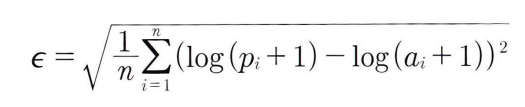

- target은 로그변환된 price값. 예측값도 로그 변환된 price값. ~> 로그로 변환된 데이터 값 수준의 price값 예측.

In [17]:
def rmsle(y, y_pred):
  # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
  return np.sqrt(np.mean(np.power(np.log1p(y)- np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    #원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    #rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [18]:
# 학습용 데이터 생성, 모델 학습/예측 로직 별도의 함수로 만들기
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소행렬 결합
    X = hstack(matrix_list).tocsr()
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df["price"],
                                                      test_size=0.2, random_state=156)
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, X_test, y_train
    gc.collect()

    return preds, y_test

In [19]:
# Ridge를 이용해 mercari price의 회귀 예측을 수행
linear_model = Ridge(solver="lsqr", fit_intercept=False)
sparse_matrix_list = (X_name, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

print("Item Description을 제외했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,\
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)

print("Item Description을 포함했을 때 rmsle 값:", evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.4983990938999374
Item Description을 포함했을 때 rmsle 값: 0.5109118267040581


### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

In [ ]:
# LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 Ensemble 방식으로 섞어서 최종 회귀 예측 평가
from lightgbm import LGBMRegressor

sparse_matrix_list = ( X_descp, X_brand, X_item_cond_id,
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print("LightGBM rmsle 값:", evaluate_org_price(y_test, lgbm_preds))
## Ridge보다 예측 성능이 더 나아졌음.

In [ ]:
# 혼합 모델 만들기
preds = lgbm_preds*0.45 + linear_preds*0.55
print("LightGBM과 Ridge를 ensemble한 최종 rmsle 값:", evaluate_org_predict(y_test,preds))

## 11. 정리
- 텍스트 사전 정제 작업 등의 텍스트 정규화 작업 수행 ~> 이들 단어들을 피처 벡터화로 변환 ~> 이렇게 생성된 피처 벡터 데이터 세트에 ML 모델을 학습하고 예측, 평가.
  - 텍스트 정규화 작업: 텍스트 클렌징 및 대소문자 변경, 단어 토큰화, 의미 없는 단어 필터링, 언근 추출 등 피처 벡터화를 진행하기 이전에 수행하는 다양한 사전 작업 의미.
    - 피처 벡터화: Bow의 대표방식인 Count기반, TF-IDF 기반 피처 벡터화 설명. ; 일반적으로 문서의 문장이 긴 경우 TF-IDF 기반의 피처 벡터가 더 정확한 결과를 도출하는데 더 도움.
  ==> 만들어진 피처 벡터 데이터 세트는 희소 행렬, ML 모델은 이러한 희소 행렬 기반에서 최적화 되어야...

- 텍스트 분류: 문서들을 피처 벡터화한 후 로지스틱 회귀를 적용해 문서를 지도학습 방식으로 예측 분류.

- 감성 분석: 지도학습 기반으로 긍정/부정 이진 분류를 적용한 방식과 같은 감성사전 Lexicon을 이용한 방식 두가지 살펴보기.

- 토픽 모델링: LDA를 이용해 뉴스그룹 내의 많은 문서들이 공통적으로 가지는 토픽 추출.

- 텍스트 군집화: K-평균 군집화 기법을 이용해 비슷한 문서들끼리 군집화

- 텍스트 유사도 측정: 코사인 유사도 이용 문서들끼리 얼마나 비슷한지 측정.